<a href="https://colab.research.google.com/github/stefanogiagu/corso_AI_2022/blob/main/notebooks/es7/MetodiAI_Fis2022_Es7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Esercitazione 7: implementazione in pytorch di una rete neurale fully connected di tipo shallow (un unico layer denso), addestrata per un task di classificazione

**Task:** Scopo: familiarizzare con l'implementazione di ANN con la libreria pytorch

**Dataset:** MNIST benchmark dataset dal repositorio pytorch

In [1]:
# import delle librerie
import numpy as np
import matplotlib.pyplot as plt

# pytorch
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

1.11.0+cu113
0.12.0+cu113


il dataset MNIST è costituito da immagini di caratteri numerici (0,1,...,9) scritti a mano corrispondenti a 60k immagini per il training e 10k immagini per il test.

Ogni immagine ha dimensione $(28,28)$ pixel, con un canale di intensità (scala di grigi) a 8 bit (valori di intensità di ogni pixel $\in [0,256]$).

È disponibile in varie librerie per il ML (scikit-learn, torch, tensorflow...), in questo hands-on utilizzeremo il campione disponibile nella libreria torch.

In [2]:
# lettura da pytorch 
from torchvision import datasets
from torchvision.transforms import ToTensor

# la funzione torchvision.datasets.MNIST accede al repositorio torch in cui è presente 
# il dataset MNIST
# il dataset è costituito da immagini in formato PIL (png), per convertirle automaticamente in tensori 
# torch si deve applicare la "trasformazione" ai dati: torchvision.transforms.ToTensor
# la funzione trasfroma l'immagine in un tensore di shape (C,H,W) = (1,28,28) in cui C=canali di colore, 
# H = numero pixel verticali, W = numero pixel orizzonatali

# NOTA: pytorch vuole le immagini nel formato (C,H,W) (a differenza di Tensorflow/keras che usano (H,W,C))

# leggiamo il dataset train
train_data = datasets.MNIST(
    root = 'data', #dove andrà a copiare i dataset scaricati
    train = True,  # True: train dataset, False: test dataset                     
    transform = ToTensor(), #trasforma i dati letti in tensori torch
    download = True,  #copia fisicamente il dataset sul disco locale (più veloce riacedere ai dati)        
)

# leggiamo il dataset test
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

print(train_data)
print(test_data)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [3]:
# train_data e test_data sono tuple che contengono coppie (immagini convertite in tensori, label)

# si può accedere alle immagini e alle label **originali** tramite i metodi .data e .targets

print('Training data shape: ',train_data.data.shape)
print('Training targets shape: ',train_data.targets.shape)
print('Test data shape: ',test_data.data.shape)
print('Test targets shape: ',test_data.targets.shape)

# prima immagine e label del campione di training

immagine = (train_data.data)[0]
label = (train_data.targets)[0]

print(type(immagine)) # tensore torch
print(type(label)) # tensore torch

print('shape immagine: ', immagine.shape)
print('shape immagine: ', immagine.numpy().shape)

print(immagine)
print(label)

# le immagini convertite internamente da ToTensor invece sono normalizzate in [0,1]
# sono queste quelle che vengono utilizzate come input alla rete neurale (per velocizzare 
# e stabilizzare il training)

print((train_data[0])[0])

Training data shape:  torch.Size([60000, 28, 28])
Training targets shape:  torch.Size([60000])
Test data shape:  torch.Size([10000, 28, 28])
Test targets shape:  torch.Size([10000])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
shape immagine:  torch.Size([28, 28])
shape immagine:  (28, 28)
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0

NOTA: normalizzazione delle fetaure in input: normalizzare l'input permette di usare learnign rate più grandi (trainign più veloce) e stabilizza l'addestramento ...

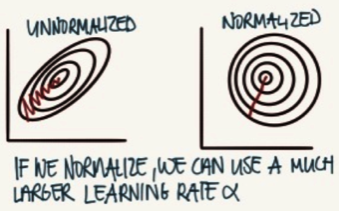

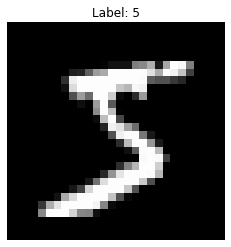

In [4]:
# grafichiamo l'immagine

plt.imshow(immagine.squeeze(), cmap='gray')
plt.title('Label: '+str(label.numpy()))
plt.axis("off")
plt.show()

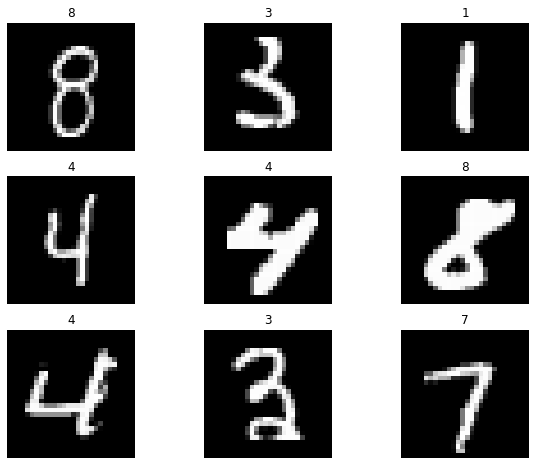

In [5]:
# grafichiamo 9 immagini random
figure = plt.figure(figsize=(10, 8))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Uso della GPU. Se si ha a disposizione una GPU può essere utilizzata per accelerare le operazioni. Questo richiede di spostare i tensori sulla GPU quando si effettuano i calcoli. È conveniente controllare se la GPU è disponibile e nel caso settare una variabile opportuna per l'uso successivo.

In [6]:
# controlliamo se la GPU è disponibile e nel caso quale tipo di GPU
if torch.cuda.is_available():
  print('Numero di GPU disponibili: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(0))

# se la GPU è disponibile setto device='cuda', altrimenti 'cpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Numero di GPU disponibili:  1
Tesla P100-PCIE-16GB
Computation device: cuda



divisione del campione in train, validation e test datasets. Non c'è una regola predefinita, dipende molto dalla dimensione del dataset totale. Tipicamente 60:20:20, ma con grandi dataset si può arrivare a 98:1:1

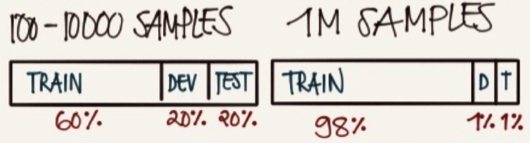

In [7]:
# per allenare la rete neurale con SGD (stochastic gradient descent), dobbiamo dividere 
# il campione di training in mini batch, e eventualmente fare un reshuffling degli eventi ad ongi epoca, 
# applicare trasformazioni etc... 

# questo viene fatto in pytorch automaticamente tramite delle helper function chiamate 
# Data Loaders

# dividiamo il dataset in due subset da 50000 e 10000 eventi da usare nel training come 
# trainign set e validation set (per tunare gli iperparametri della rete)

tr_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])

from torch.utils.data import DataLoader

# costruiamo tre loader (train, val e test) (volendo si può anche costruire un dizionario che li 
# legga insieme)

batch = 100
train_dl = DataLoader(tr_data, 
                      batch_size=batch, 
                      shuffle=True, 
                      num_workers=1)

vali_dl = DataLoader(val_data, 
                      batch_size=batch, 
                      shuffle=True,
                      num_workers=1)
    
test_dl = DataLoader(test_data, 
                     batch_size=batch, 
                     shuffle=True,
                     num_workers=1)

Feature batch shape: torch.Size([100, 1, 28, 28])
Labels batch shape: torch.Size([100])
Feature:


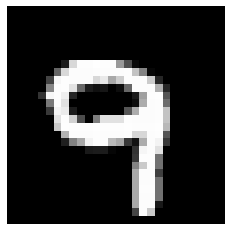

Label: 9


In [8]:
# ogni data loader fornisce un iteratore con il quale si possono accedere ai vari mini-batch del dataset

feat, label = next(iter(train_dl))

print(f"Feature batch shape: {feat.size()}")
print(f"Labels batch shape: {label.size()}")

an_event = feat[0].squeeze() #squeeze elimina la dimensione 1 (1,28,28)->(28,28)
a_label = label[0]

print(f"Feature:")
plt.imshow(an_event, cmap='gray')
plt.axis("off")
plt.show()
print(f"Label: {a_label}")

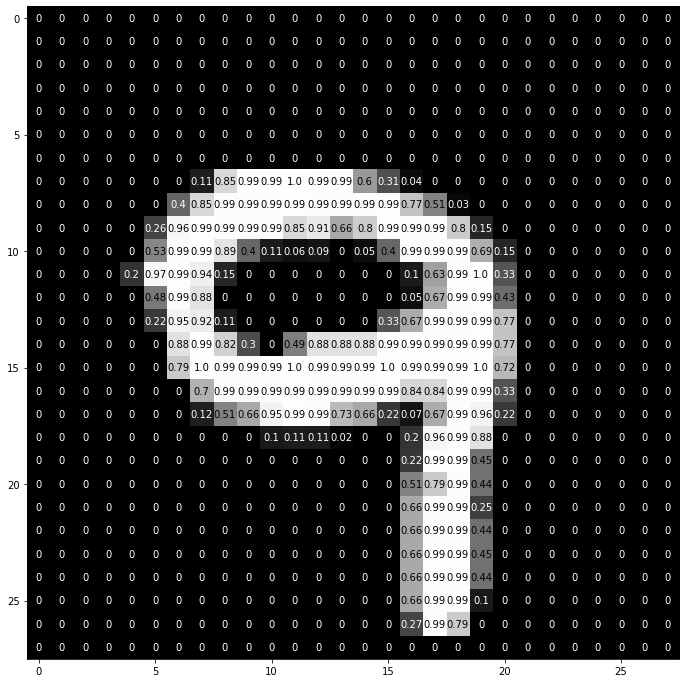

In [9]:
# dettagli su come è fatta un'immagine

img = an_event.numpy()

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

### Definzione del modello di rete neurale.

Archiettura: MLP shallow con layer densi (Linear in pytorch):
 con 1 solo layer hidden con attivazioni ReLU, e 10 neuroni di output con attivazione softmax che predicono la probabilità che l'immagine appartenga ad una delle 10 classi possibili:

*   input layer: 28x28=784 neuroni
*   hidden layer: 1024 neuroni, attivazione ReLU
*   output layer: 10 neuroni, attivazione softmax

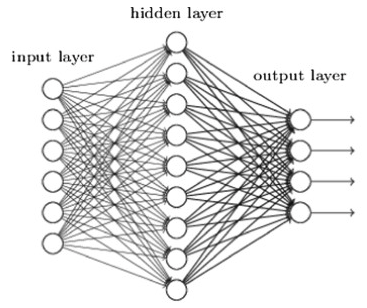

In [10]:
from torch import nn
import torch.nn.functional as F

# in pytorch una rete neurale viene implementata costruendo una classe python che eredita 
# dalla classe di pytorch nn.Module e implementa due metodi di base:
# __init__: definizione dei layer utlizzati
# forward: funzione che calcola y = ANN(x)

class ShallowMLP(nn.Module):
  def __init__(self, input_dim=784, output_dim=10, hidden_dim=1024):
    super(ShallowMLP, self).__init__()
    
    #torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
    self.layer1 = nn.Linear(input_dim, hidden_dim)  #hidden layer
    self.layer2 = nn.Linear(hidden_dim, output_dim) #output layer
    
  def forward(self, x):
    x = self.layer1(x)
    x = F.relu(x)
    out = self.layer2(x)
    #out = F.log_softmax(x, dim=1)
    return out

In [ ]:
!pip install torchsummary

In [11]:
# printout del modello

model = ShallowMLP()
print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,784))
else:
  summary(model, input_size=(1,784))

ShallowMLP(
  (layer1): Linear(in_features=784, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1024]         803,840
            Linear-2                [-1, 1, 10]          10,250
Total params: 814,090
Trainable params: 814,090
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 3.11
Estimated Total Size (MB): 3.12
----------------------------------------------------------------


In [12]:
# testiamo un batch sul modello non addestrato per vedere che le cose funzionino

feat, label = next(iter(train_dl))

feat=feat.to(device)
label=label.to(device)

out = model(feat.view(batch,-1))

print(out.shape)
print(out[0])

torch.Size([100, 10])
tensor([ 0.0248, -0.0800, -0.0641,  0.0101,  0.0545, -0.0095,  0.0328, -0.0991,
        -0.0317, -0.0070], device='cuda:0', grad_fn=<SelectBackward0>)


In [13]:
# Per completare il modello dobbiamo definire la loss function, le eventuali metriche per monitorare il 
# training della rete, e infine l'ottimizzatore

# loss function 
loss_func = nn.CrossEntropyLoss() #cross entropy loss (loss molto usata per classificazione multi classe)
# loss_func = nn.NLLLoss() #alteranativamente con log_softmax (stesso risultato)

# metric accuracy (in questo caso dobbiamo scrivercela da noi perché non è disponibile builtin in pytorch)
def accuracy(yhat, y):
    preds = torch.max(yhat,1)[1] #predizioni == neuroni con la massima probabilità
    batch_acc = (preds == y).sum()
    return batch_acc

metric_func = accuracy

# ottmizzatore: usiamo per esempio la discesa stocastica lungo il gradiente con momentum
from torch import optim
opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [14]:
# vogliamo usare la GPU quindi spostiamo il modello sulla GPU
model.to(device)
print(next(model.parameters()).device)

cuda:0


In [15]:
# in pytorch è necessario scriversi il loop di training, cioè il loop sulle epoch di training in cui in ogni 
# epoca si leggono tutti gli eventi del dataset aggiornando i pesi dopo ogni mini-batch

import time

# numero di epoche
epochs = 100

# liste su cui salvare il valore della loss e della metrica ad ogni epoca per poterli graficare in funzione 
# dell'epoca a fine addestramento
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []


# loop sulle epoche
for epoch in range(epochs):
    t0 = time.time()
    
    # training step (in cui aggiorniamo i pesi della rete neurale)
    model.train()
    train_loss = 0
    train_metric = 0
    counter = 0
    for xb, yb in train_dl:
        counter += 1
        xb=xb.to(device) #copio il mini batch di dati sulla CPU/GPU
        yb=yb.to(device) #copio il mini batch di label sulla CPU/GPU

        pred = model(xb.view(batch,-1)) #predizione del modello (si aspetta un vettore piatto di dimensione (batch,28*28))

        # calcolo loss e metrica
        loss = loss_func(pred, yb)
        metric = metric_func(pred, yb)

        # aggiorno la loss e metrica totale
        train_loss += loss.item()
        train_metric += metric.item()

        # backpropagation
        opt.zero_grad() #resetta i gradienti prima di eseguire la backpropagation
        loss.backward() #calcola i gradeinti della loss
        opt.step() #aggiorna i pesi


    train_loss /= counter
    train_metric /= (counter*batch)
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)

    # validation step (non vengono aggiornati i pesi)
    model.eval()
    vali_loss = 0
    vali_metric = 0
    counter = 0
    with torch.no_grad(): #evita che si aggiornino i pesi
      for xb, yb in vali_dl:
        counter += 1
        xb=xb.to(device)
        yb=yb.to(device)

        pred = model(xb.view(batch,-1)) #predizione del modello (si aspetta un vettore piatto di dimensione (batch,28*28))

        # calcolo loss e metrica
        vloss = loss_func(pred, yb)
        vmetric = metric_func(pred, yb)
        vali_loss += vloss.item()
        vali_metric += vmetric.item()  

    vali_loss /= counter
    vali_metric /= (counter*batch)
    hist_vloss.append(vali_loss)
    hist_vmetric.append(vali_metric)

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f" 
          % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))

epoch: 1, time(s): 10.7884, train loss: 1.539683, train metric: 0.705280, vali loss: 0.877687, vali metric: 0.830300
epoch: 2, time(s): 10.4697, train loss: 0.667543, train metric: 0.851400, vali loss: 0.548180, vali metric: 0.869300
epoch: 3, time(s): 10.4873, train loss: 0.486757, train metric: 0.876800, vali loss: 0.449844, vali metric: 0.883200
epoch: 4, time(s): 10.4590, train loss: 0.417989, train metric: 0.889420, vali loss: 0.403117, vali metric: 0.890200
epoch: 5, time(s): 10.4354, train loss: 0.380660, train metric: 0.895980, vali loss: 0.374580, vali metric: 0.895800
epoch: 6, time(s): 11.4759, train loss: 0.356349, train metric: 0.901800, vali loss: 0.354818, vali metric: 0.900400
epoch: 7, time(s): 10.5511, train loss: 0.338290, train metric: 0.905980, vali loss: 0.341218, vali metric: 0.903800
epoch: 8, time(s): 10.7344, train loss: 0.324397, train metric: 0.908860, vali loss: 0.328002, vali metric: 0.906200
epoch: 9, time(s): 10.4972, train loss: 0.312317, train metric: 

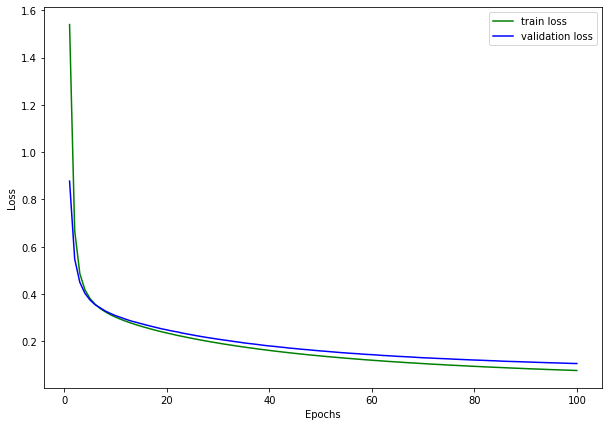

In [16]:
# grafico loss vs epoca
plt.figure(figsize=(10, 7))
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

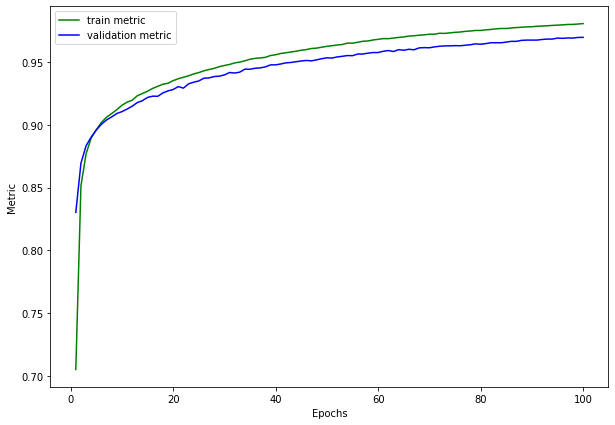

In [17]:
# grafico accuracy vs epoca
plt.figure(figsize=(10, 7))
plt.plot(range(1,len(hist_metric)+1),hist_metric, color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [18]:
# Salvataggio del modello

torch.save(model, './trained_model.pt')

In [19]:
# Uso di un modello addestrato in inferenza (predizione) 

# lettura del modello

model = torch.load('./trained_model.pt')
model.eval() #va sempre fatto per settare eventuali layer di droput e batch norm in evaluation model

# Non è strettamento necessario girare sulla GPU per l'inferenza (non richiede grande potenza di calcolo)
model.to(torch.device('cpu'))

loss = 0
metric = 0
counter = 0

for xb, yb in test_dl:
  counter += 1
  xb=xb.to('cpu')
  yb=yb.to('cpu')
  pred = model(xb.view(batch,-1))

  loss += loss_func(pred, yb).item()
  metric += accuracy(pred, yb).item()


loss /= counter
metric /= (counter*batch)

print('Test loss/accuracy: ',loss, ' / ', metric)

Test loss/accuracy:  0.09611272659152746  /  0.9724


### Compiti:


*   giocate con il codice e i parametri per capire come funziona il tutto, diminuite il numero di neuroni del layer hidden, come decadono le prestazioni della rete in termini di accuracy?
*   provare a cambiare l'attivazione del layer hidden della rete da ReLU a F.tanh o F.sigmoid
*   provare ad aggiungere un secondo layer hidden alla rete con 512 neuoroni, come cambiano le prestazioni?
*   provare a giocare con la batch size, cosa succede se si usa una bacth size per cui il numero di eventi nei dataset non è divisibile? Come si può risolvere il problema? 
*   provare ad eliminare il momentum dall'ottmizzatore SGD e provare diversi valori del learning rate da 0.1 a 0.0001 cosa cambia?
*   provare a cambiare la funzione di ottimizzazione, usando *torch.optim.Adam* con parametri di default, cosa cambia?

